In [1]:
!nvidia-smi

Fri Feb 26 01:08:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 450.57       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:18:00.0 Off |                  N/A |
| 37%   54C    P8    16W / 250W |      3MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import wandb
from sklearn.model_selection import train_test_split
import os
import random
import collections

In [3]:
os.getcwd()
# os.environ['CUDA_VISIBLE_DEVICES'] = "0" 
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)]) 
#     except RuntimeError as e:
#         print(e)
wandb.init(project = "animal")

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: wr80340 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.20 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [4]:
classes = []
img_path = []
label = []
tmp = []
for dirpath, dnames, fnames in os.walk("./oregon_wildlife/oregon_wildlife/"):
    for d in dnames:
        classes.append(d)
        
for i in range(len(classes)):
    tmp.append("./oregon_wildlife/oregon_wildlife/" + classes[i] + "/")
    
idx = 0
for path in tmp:
    for _, _, fnames in os.walk(path):
        for f in fnames:
            if f[-3:] not in ('gif','bmp'):
                img_path.append(path + f)
                label.append(classes[idx])
        idx += 1
dt = list(zip(img_path, label))
random.shuffle(dt)
img_path, label = zip(*dt)
label = list(label)
print("total num of pic {:0}".format(len(label)))
class_name = np.unique(label)
collections.Counter(label)

total num of pic 13951


Counter({'seals': 695,
         'bald_eagle': 744,
         'gray_fox': 668,
         'virginia_opossum': 726,
         'red_fox': 757,
         'bobcat': 690,
         'raven': 650,
         'mountain_beaver': 575,
         'columbian_black-tailed_deer': 735,
         'elk': 660,
         'coyote': 736,
         'black_bear': 715,
         'sea_lions': 725,
         'cougar': 673,
         'nutria': 691,
         'deer': 763,
         'gray_wolf': 730,
         'canada_lynx': 713,
         'raccoon': 724,
         'ringtail': 581})

In [5]:
label_to_index = dict((name, index) for index,name in enumerate(class_name))
index_to_label = dict((index, name) for index,name in enumerate(class_name))
index = [label_to_index[lab] for lab in label]
index[:5]

[18, 0, 9, 19, 15]

In [6]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH = 224, 224, 3
IMAGE_SIZE_CROPPED = 200
BATCH_SIZE = 8
LR = 1e-4
EPOCH = 100
last_layer_length = len(class_name)

scce = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM)

train_inception_loss = tf.keras.metrics.Mean()
train_inception_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

val_inception_loss = tf.keras.metrics.Mean()
val_inception_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

test_inception_loss = tf.keras.metrics.Mean()
test_inception_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

optimizer = tf.keras.optimizers.SGD(lr = LR)

In [7]:
def load_image(image_path, index):
    # inception : tf, [-1,1]
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, index

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


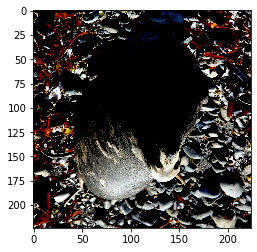

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


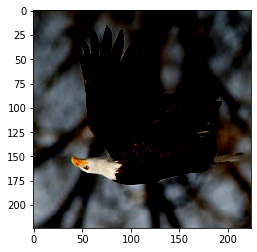

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


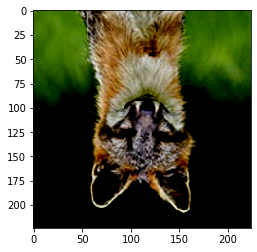

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


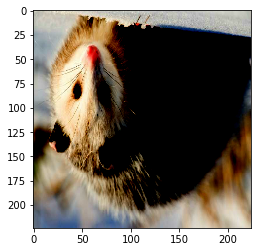

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


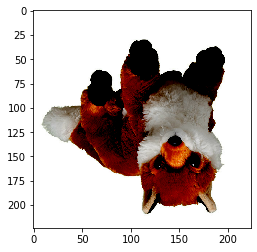

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


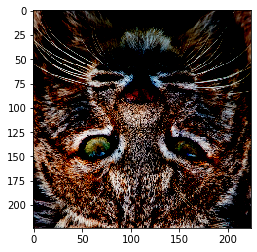

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


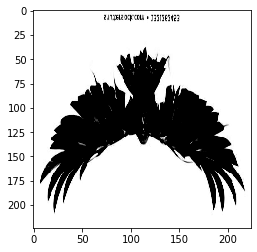

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


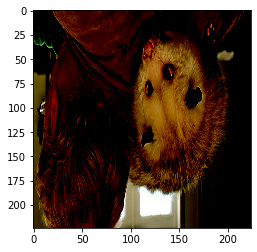

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


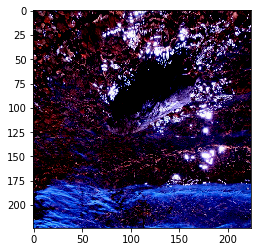

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


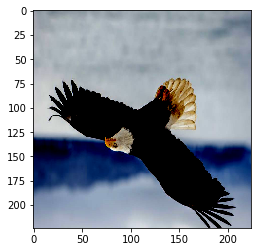

In [8]:
for i in range(10):
    plt.imshow(load_image(img_path[i], label[i])[0][::-1])
    plt.show()

In [9]:
img_path_train, img_path_test, img_index_train, img_index_test = train_test_split(img_path, index, test_size=0.3, random_state = 1122)
img_path_train, img_path_val, img_index_train, img_index_val = train_test_split(img_path_train, img_index_train, test_size=0.3, random_state = 1122)
assert len(np.unique(img_index_train)) == last_layer_length & len(np.unique(img_index_test)) == last_layer_length & len(np.unique(img_index_val)) == last_layer_length
print("number of training data {}, number of validation data {}".format(len(img_index_train), len(img_index_val)))

number of training data 6835, number of validation data 2930


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


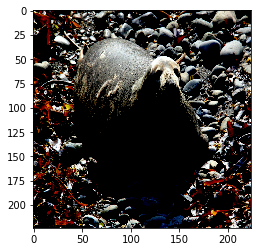

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


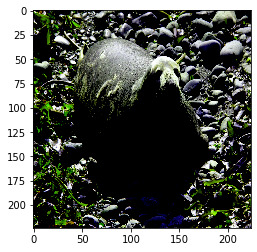

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


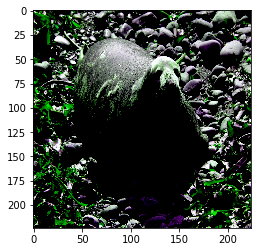

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


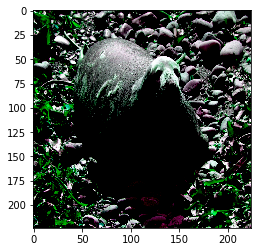

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


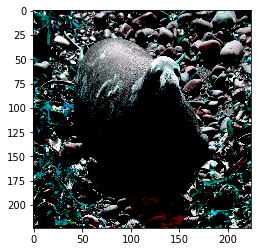

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


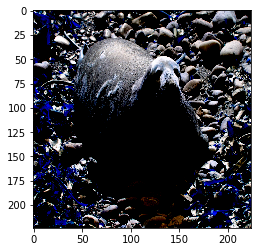

In [10]:
# must be in [0,0.5]
tmp_img = load_image(img_path[0], label[0])[0]
plt.imshow(tmp_img)
plt.show()
for num in [0.1,0.2,0.3,0.4,0.5]:
    plt.imshow(tf.image.adjust_hue(tmp_img, num))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


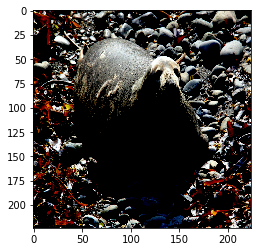

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


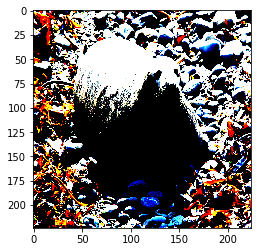

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


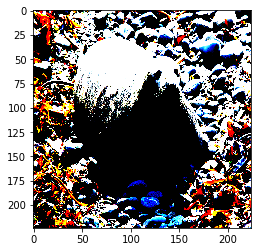

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


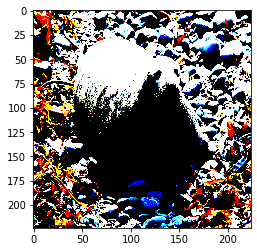

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


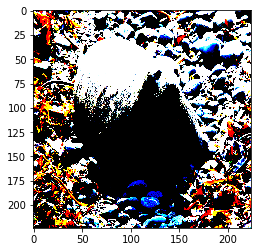

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


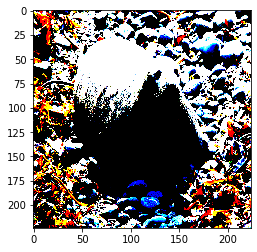

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


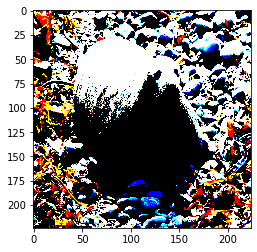

In [11]:
plt.imshow(tmp_img)
plt.show()
for num in [4,5,6,7,8,9]:
    plt.imshow(tf.image.adjust_contrast(tmp_img, num))
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


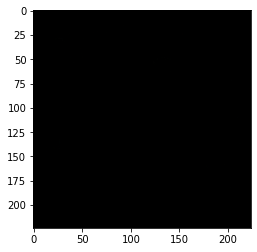

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


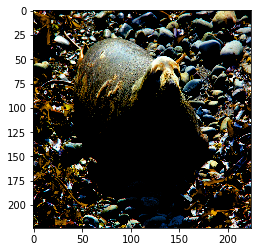

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


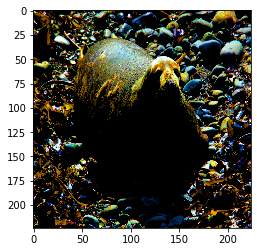

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


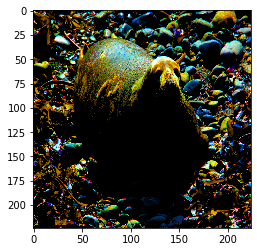

In [12]:
plt.imshow(tmp_img/255)
plt.show()
for num in [3,6,9]:
    plt.imshow(tf.image.adjust_saturation(tmp_img, num))
    plt.show()


In [13]:
def map_fn(image, index):
    # location mapping
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_crop(image, [IMAGE_SIZE_CROPPED, IMAGE_SIZE_CROPPED, IMAGE_DEPTH])
    # color mapping
    trigger = tf.random.uniform([])
    if trigger < 0.2:
        image = tf.image.adjust_contrast(image, 3)
    elif trigger < 0.4:
        image = tf.image.adjust_saturation(image, 3)
    elif trigger < 0.6:
        image = tf.image.adjust_hue(image, 0.5)
    # assert size = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH)
    image = tf.image.resize_with_crop_or_pad(image, IMAGE_HEIGHT, IMAGE_WIDTH)
    return image, index


In [14]:
dataset_train = tf.data.Dataset.from_tensor_slices((img_path_train, img_index_train))
dataset_train = dataset_train.repeat(3)
dataset_train = dataset_train.shuffle(1122)
dataset_train = dataset_train.map(load_image)
dataset_train = dataset_train.map(map_fn)


dataset_val = tf.data.Dataset.from_tensor_slices((img_path_val, img_index_val))
dataset_val = dataset_val.map(load_image)

dataset_test = tf.data.Dataset.from_tensor_slices((img_path_test, img_index_test))
dataset_test = dataset_test.map(load_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


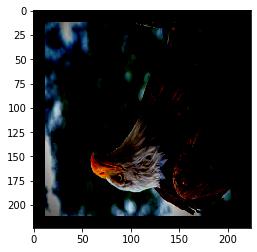

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(0, shape=(), dtype=int32)


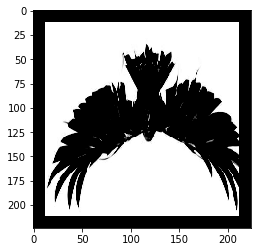

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(14, shape=(), dtype=int32)


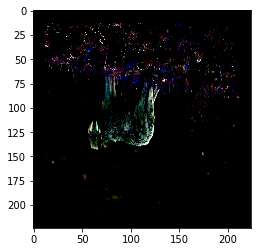

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(10, shape=(), dtype=int32)


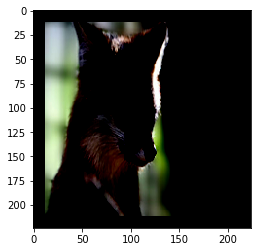

tf.Tensor(9, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


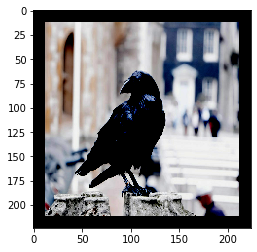

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(14, shape=(), dtype=int32)


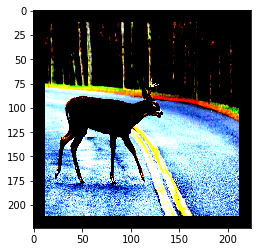

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(7, shape=(), dtype=int32)


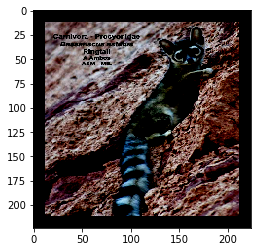

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(16, shape=(), dtype=int32)


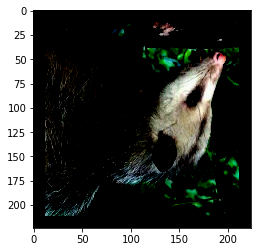

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(19, shape=(), dtype=int32)


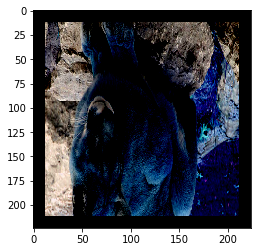

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(5, shape=(), dtype=int32)


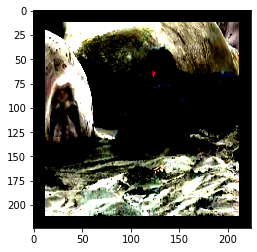

tf.Tensor(18, shape=(), dtype=int32)


In [15]:
for image, index in dataset_train.take(10):
    plt.imshow(image)
    plt.show()
    print(index)

In [16]:
dataset_train = dataset_train.batch(BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_val = dataset_val.batch(BATCH_SIZE)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_test = dataset_test.batch(BATCH_SIZE)
dataset_test = dataset_test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [17]:
img_inputs = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
inceptionv3 = tf.keras.applications.InceptionV3(include_top = False, weights = 'imagenet')
for layers in inceptionv3.layers:
    layers.trainable = False
x = inceptionv3(img_inputs)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation = "relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(2048, activation = "relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(1024, activation = "relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

out = tf.keras.layers.Dense(last_layer_length, activation = "softmax")(x)
model = tf.keras.Model(inputs=img_inputs, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         multiple                  21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              209719296 
_________________________________________________________________
batch_normalization_94 (Batc (None, 4096)              16384     
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              839065

In [18]:
@tf.function
def train_step(image, index):
    with tf.GradientTape() as tape:
        preds = model(image)
        loss = scce(index, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    train_inception_loss(loss)
    train_inception_accuracy(index, preds)

@tf.function
def val_step(image, index):
    preds = model(image)
    loss = scce(index, preds)
    
    val_inception_loss(loss)
    val_inception_accuracy(index, preds) 
    
@tf.function
def test_step(image, index):
    preds = model(image)
    loss = scce(index, preds)
    
    test_inception_loss(loss)
    test_inception_accuracy(index, preds)

In [19]:
for epoch in range(EPOCH):    
    for (train_image, train_index), (val_image, val_index) in zip(dataset_train, dataset_val): 
        train_step(train_image, train_index)
        val_step(val_image, val_index)

    wandb.log({
        "training accuracy" : train_inception_accuracy.result().numpy(),
        "training loss" : train_inception_loss.result().numpy(),
        "validation accuracy" : val_inception_accuracy.result().numpy(),
        "validation loss" : val_inception_loss.result().numpy(),
    })
    if (epoch+1) % 5 == 0:
        tmp = "EPOCH {:0}, train accuracy {:.2f}, train loss {:.2f}, val accuracy {:.2f}, val loss {:.2f}"
        print(tmp.format(epoch+1, train_inception_accuracy.result().numpy(), train_inception_loss.result().numpy(), val_inception_accuracy.result().numpy(), val_inception_loss.result().numpy()))

train_inception_loss.reset_states()
train_inception_accuracy.reset_states()
val_inception_loss.reset_states()
val_inception_accuracy.reset_states()

EPOCH 5, train accuracy 0.55, train loss 11.48, val accuracy 0.74, val loss 6.42
EPOCH 10, train accuracy 0.61, train loss 9.84, val accuracy 0.77, val loss 5.56
EPOCH 15, train accuracy 0.65, train loss 8.91, val accuracy 0.78, val loss 5.18
EPOCH 20, train accuracy 0.67, train loss 8.26, val accuracy 0.79, val loss 4.96
EPOCH 25, train accuracy 0.69, train loss 7.76, val accuracy 0.80, val loss 4.82
EPOCH 30, train accuracy 0.71, train loss 7.33, val accuracy 0.80, val loss 4.72
EPOCH 35, train accuracy 0.73, train loss 6.96, val accuracy 0.81, val loss 4.64
EPOCH 40, train accuracy 0.74, train loss 6.64, val accuracy 0.81, val loss 4.58
EPOCH 45, train accuracy 0.75, train loss 6.37, val accuracy 0.81, val loss 4.53
EPOCH 50, train accuracy 0.76, train loss 6.13, val accuracy 0.82, val loss 4.49
EPOCH 55, train accuracy 0.77, train loss 5.91, val accuracy 0.82, val loss 4.45
EPOCH 60, train accuracy 0.78, train loss 5.71, val accuracy 0.82, val loss 4.42
EPOCH 65, train accuracy 0.7

In [20]:
for test_image, test_index in dataset_test: 
    test_step(test_image, test_index)
tmp = "test accuracy {:.2f}, test loss {:.2f}"
print(tmp.format(test_inception_accuracy.result().numpy(), test_inception_loss.result().numpy()))

NameError: name 'test_resnet_accuracy' is not defined